# Training

In [ ]:
!pip install tensorboardX
!pip install uncertainty-metrics

In [ ]:
!git clone https://github.com/pollinab/repulsive_ensembles.git

In [ ]:
%cd repulsive_ensembles

/content/repulsive_ensembles


In [ ]:
!gzip -d data/notMNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
!gzip -d data/notMNIST/MNIST/raw/t10k-images-idx3-ubyte.gz

In [ ]:
#!python setup.py install

In [ ]:
#!python experiments/exp_mnist.py

In [ ]:
from utils.mnist_config import configuration
from training.train_classifier import train
from models.MLP import Net
from models.ensemble import Ensemble
from torchvision.datasets import MNIST
import numpy as np
import torch.nn.functional as F
from IPython.display import clear_output
from tqdm.notebook import tqdm
from torchvision import transforms
import os
import torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
test_set = MNIST(os.getcwd(), train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)

test_x, test_labels = next(iter(test_loader))

ood_set = MNIST('data/notMNIST', train=False, transform=transform, download=False)
ood_loader = torch.utils.data.DataLoader(ood_set, batch_size=len(ood_set), shuffle=False)

ood_data, ood_labels = next(iter(ood_loader))

In [ ]:
n_particles = 15
layer_sizes = [28*28, 100, 100, 100, 10]

mnet = Net(layer_sizes, classification=True, act=F.relu, out_act =F.softmax, bias=True).to(device)

l = []
for _ in range(n_particles):
  l.append(torch.cat([p.flatten() for p in Net(layer_sizes, classification =True, act=F.relu,out_act =F.softmax, bias=True, no_weights=False).parameters()][len(mnet.param_shapes):]).detach())

initial_particles = torch.stack(l).to(device)

ensemble = Ensemble(device = device, net=mnet,particles=initial_particles)

In [ ]:
config = configuration(args=['--n_epochs', '15', '--method', 'kde', '--kernel', 'laplace', '--adversarial', 'True', '--functional', 'False'])

In [ ]:
train_history = train(ensemble, train_loader, config)

-------------------Start training------------------
Train epoch: 0  train loss: 24653.156559870793 driving: 0.05697566643357277 repulsive: 7.623332203365862e-05
Train epoch: 1  train loss: 12369.114429962941 driving: 0.043296508491039276 repulsive: 5.421404057415202e-05
Train epoch: 2  train loss: 9889.369283040365 driving: 0.03166868910193443 repulsive: 3.922287578461692e-05
Train epoch: 3  train loss: 8167.597655206664 driving: 0.023137465119361877 repulsive: 2.3910009986138903e-05
Train epoch: 4  train loss: 6978.299867809328 driving: 0.026915540918707848 repulsive: 1.3931750800111331e-05
Train epoch: 5  train loss: 5972.228214100895 driving: 0.027706213295459747 repulsive: 1.2574885658978019e-05
Train epoch: 6  train loss: 5192.544890183669 driving: 0.020797360688447952 repulsive: 8.835922926664352e-06
Train epoch: 7  train loss: 4479.3489001673515 driving: 0.016705216839909554 repulsive: 7.137105512811104e-06
Train epoch: 8  train loss: 3885.1610331739116 driving: 0.01581312902271

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

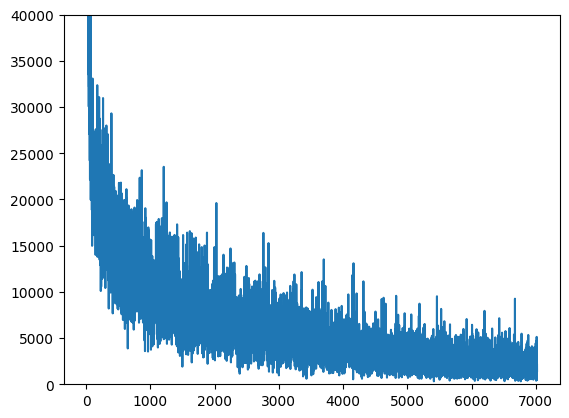

In [ ]:
plt.plot(train_history['train']['loss'])
plt.ylim([0,40000])
plt.show()

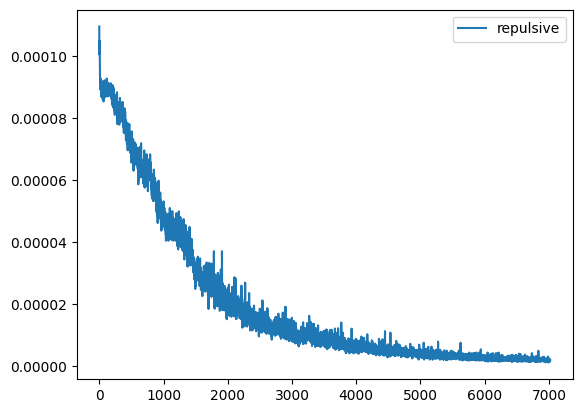

In [ ]:
#plt.plot(train_history['train']['driving'], label='driving')
plt.plot(train_history['train']['repulsive'], label='repulsive')
plt.legend()
plt.show()

# Evaluation

In [ ]:
from utils.evaluation import evaluate

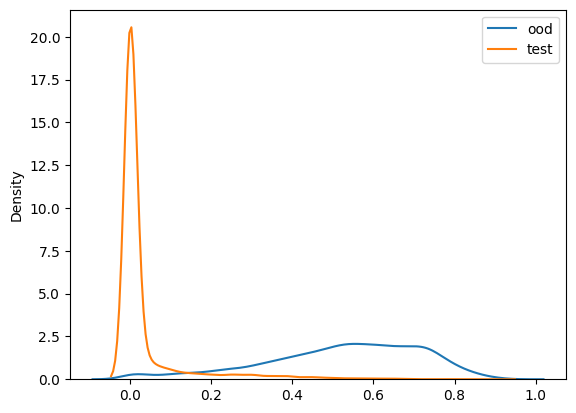

Test accuracy: 98.06 , nll loss: 0.06328949332237244 , test ECE: 0.00823913744390019 , entropies ratio: 14.90565299987793


In [ ]:
ent_ood, ent_test,_ = evaluate(ensemble, test_x, test_labels, ood_data)

### Plots for different number of models

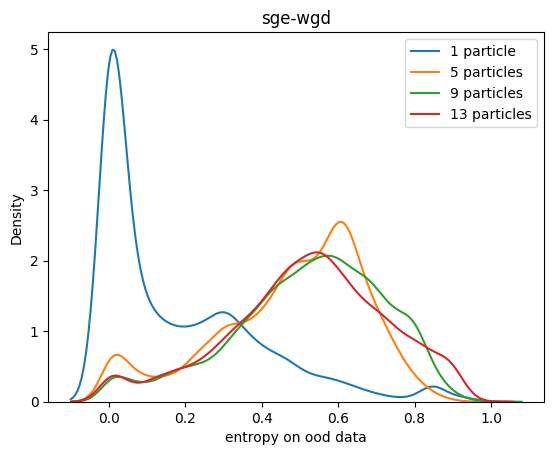

In [ ]:
sns.kdeplot(ent_ood_1, label='1 particle')
sns.kdeplot(ent_ood_5, label='5 particles')
sns.kdeplot(ent_ood_9, label='9 particles')
sns.kdeplot(ent_ood_13, label='13 particles')
plt.xlabel('entropy on ood data')
plt.title('sge-wgd')
plt.legend()
plt.show()

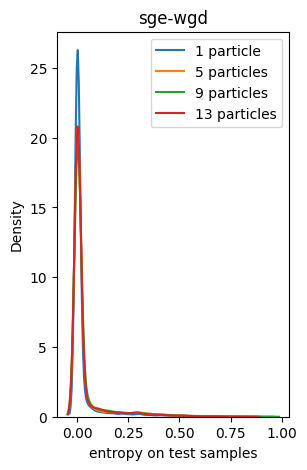

In [ ]:
plt.figure(figsize=(3, 5))
sns.kdeplot(ent_test_1, label='1 particle')
sns.kdeplot(ent_test_5, label='5 particles')
sns.kdeplot(ent_test_9, label='9 particles')
sns.kdeplot(ent_test_13, label='13 particles')
plt.xlabel('entropy on test samples')
plt.title('sge-wgd')
plt.legend()
plt.show()

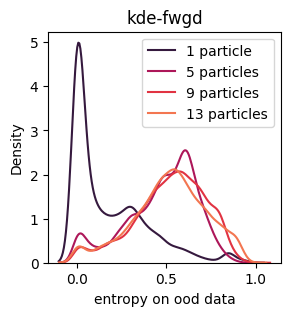

In [ ]:
plt.figure(figsize=(3, 3))
colors = sns.color_palette("rocket")
sns.kdeplot(ent_ood_1, label='1 particle',  c=colors[0])
sns.kdeplot(ent_ood_5, label='5 particles',  c=colors[2])
sns.kdeplot(ent_ood_9, label='9 particles', c=colors[3])
sns.kdeplot(ent_ood_13, label='13 particles',  c=colors[4])
plt.xlabel('entropy on ood data')
plt.title('kde-fwgd')
plt.legend()
plt.show()

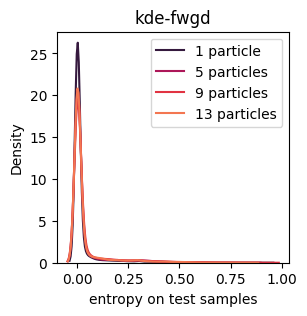

In [ ]:
plt.figure(figsize=(3, 3))
colors = sns.color_palette("rocket")
sns.kdeplot(ent_test_1, label='1 particle', c=colors[0])
sns.kdeplot(ent_test_5, label='5 particles', c=colors[2])
sns.kdeplot(ent_test_9, label='9 particles', c=colors[3])
sns.kdeplot(ent_test_13, label='13 particles', c=colors[4])
plt.xlabel('entropy on test samples')
plt.title('kde-fwgd')
plt.legend()
plt.show()

In [ ]:
#Some results (accuracy, nll, ece, entropies ratio)

# train(ensemble, train_loader, len(train_set), test_x, test_labels, anneal=0.01,n_epochs=15, method='kde', lr=0.01, is_functional=False, kernel=RBF())
# [97.81, 0.07373585551977158, 0.006942067825794254, 12.37319564819336]
# 1 particle
# [96.98, 0.10516248643398285, 0.012921993799507602, 8.321293830871582]
# 9 particles
# [98.06, 0.06924691051244736, 0.010174385190010049, 12.554532051086426]
# 13 particles
# [97.85000000000001, 0.0657600536942482, 0.007124843616783614, 13.401883125305176]

# 1 particles, sge
#[97.09, 0.10619939863681793, 0.011444389890134405, 7.327690601348877]
# 5 particles, sge
# [97.74000000000001, 0.07038144022226334, 0.006583130586147265, 13.47141170501709]
# 9 particles, sge
# [97.83, 0.06922736763954163, 0.009320798471570028, 12.308741569519043]
# 13 particles, sge
# [97.82, 0.07154838740825653, 0.009906672421097704, 12.855205535888672]
# 17 particles, sge
# [98.0, 0.05925857648253441, 0.007160805636644409, 14.344250679016113]

# 5 particles, f_kde
# [97.77, 0.07030083239078522, 0.006910092857480037, 13.41624641418457]
# 9, f-kde
# [97.77, 0.07030138373374939, 0.007824249534308913, 13.572866439819336]
# 13, f-kde
# [98.03, 0.06387758255004883, 0.008248321679234494, 14.910234451293945]
# 17
# [97.81, 0.06734057515859604, 0.008713640221953357, 13.659160614013672]


# 5 particles, none
# [97.84, 0.06939263641834259, 0.005750743278861069, 12.625537872314453]
# 9
# [97.84, 0.07036110013723373, 0.008717522987723353, 12.700540542602539]
# 13
# [97.82, 0.06883402168750763, 0.008436276364326444, 12.60865306854248]
# 17
# [98.04, 0.05978789180517197, 0.008344137096405038, 13.957160949707031]


# 5 particles,kde, laplace
# [97.86, 0.0658423975110054, 0.0048884822875261144, 13.517887115478516]
# 9 particles, laplace
# [98.11, 0.06172558665275574, 0.005859654107689885, 14.066964149475098]
# 13 particles, laplace
# [98.0, 0.06307438015937805, 0.0077836716473102825, 13.442367553710938]
# 17 particles, laplace
# [98.04, 0.05991411209106445, 0.006285130202770202, 14.152632713317871]

# 5 particles, f-ssge, laplace
# [97.94, 0.06908073276281357, 0.006711472432315282, 12.809236526489258]

# 13, kde, linear
# [97.88, 0.06555214524269104, 0.008164442065358168, 12.917657852172852]

#5, kde, +adversarial
#[97.83, 0.06521999835968018, 0.006745656239986405, 12.957584381103516]
#9, kde, +adversarial
#[97.91, 0.06394092738628387, 0.007322092923522014, 13.355695724487305]
#13, kde, +adversarial
#[97.92999999999999, 0.06422688812017441, 0.007796208605170204, 13.524588584899902]
#17, kde, +adversarial
#[98.08, 0.06409850716590881, 0.009522903147339796, 13.10159969329834]

# 17 particles, n_epochs=25, method='kde', lr=0.01, is_functional=True, adversarial=True
# [98.00999999999999, 0.0635431632399559, 0.006622979778051381, 16.875986099243164]